# Cox survival model
This notebook implements the Cox Survival model for Heart Failure patients (with functional covariates).

In [1]:
require(data.table)
require(ggplot2)
require(survival)
library(corrplot)

options(repr.plot.width=4, repr.plot.height=4)

Loading required package: data.table
Loading required package: ggplot2
Loading required package: survival
corrplot 0.84 loaded


In [2]:
path = '/Users/davide/Documents/universita/tesi/src/survival_process/'
setwd(path)

load('../../data/main_process_preprocessed_data.RData')

In [4]:
head(new_df)

id,sex,age_in,time_event,status,ACE_PC1,ACE_PC2,aldosteronics_PC1,aldosteronics_PC2,beta_PC1,beta_PC2,hospitalisation_PC1,hospitalisation_PC2
10000243,M,70,51,1,-40.851181,1.0158516,48.46830,3.2253751,12.973675,5.717680,11.7766373,2.7808122
10000471,F,80,1058,1,-41.405426,0.8888934,-19.60667,0.6522028,-35.083338,1.060089,7.5054363,-0.5748265
10000717,M,73,705,0,-10.854551,-9.4426737,-20.13732,0.5456685,-9.574883,-5.179390,1.4768682,0.3687805
10003004,F,75,1658,1,4.612457,-2.4369352,-19.60667,0.6522028,-34.491256,1.175663,-4.2522032,-0.2800180
10006065,M,69,1950,0,61.216558,6.4277908,61.04541,6.8178757,-33.752005,1.319964,0.4320898,0.1475507
10007000,F,84,238,1,-2.634210,3.4520296,-10.91626,-2.8554621,-4.906371,5.629327,2.7059192,-0.5461010


In [5]:
dim(new_df)

[1] 3179   13

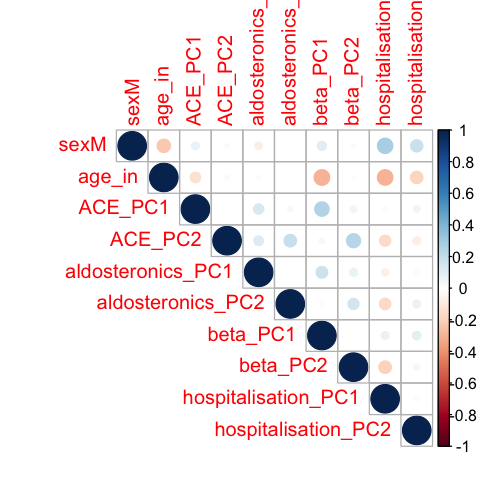

In [6]:
cols = c('age_in','ACE_PC1','ACE_PC2','aldosteronics_PC1','aldosteronics_PC2','beta_PC1','beta_PC2','hospitalisation_PC1','hospitalisation_PC2')
corrplot(cor(cbind(sexM = ifelse(new_df$sex == 'M',1,0),new_df[,..cols])),type = "upper")

# Cross Validate

In [6]:
set.seed(143)
#Randomly shuffle the observations
new_df = new_df[sample(1:dim(new_df)[1]),]
#Create 10 equally size folds
folds <- cut(seq(1,dim(new_df)[1]),breaks=10,labels=FALSE)

#Perform 10 fold cross validation
scores = NULL
pb <- txtProgressBar(min = 0, max = 10, style = 3)
for(i in 1:10){
    setTxtProgressBar(pb, i)
    #Segement data by fold 
    validIndexes <- which(folds==i,arr.ind=TRUE)
    valid = new_df[validIndexes,]
    train = new_df[-validIndexes,]

    # fit
    models = list(
        coxph(Surv(time_event,status)~ age_in + sex , data = train),
        # single process effect, 1 or 2 Principal components
        coxph(Surv(time_event,status)~ age_in  + ACE_PC1, data = train),
        coxph(Surv(time_event,status)~ age_in  + ACE_PC1 + ACE_PC2, data = train),
        coxph(Surv(time_event,status)~ age_in  + aldosteronics_PC1, data = train),
        coxph(Surv(time_event,status)~ age_in  + aldosteronics_PC1 + aldosteronics_PC2, data = train),
        coxph(Surv(time_event,status)~ age_in  + beta_PC1, data = train),
        coxph(Surv(time_event,status)~ age_in  + beta_PC1 + beta_PC2, data = train),
        coxph(Surv(time_event,status)~ age_in  + hospitalisation_PC1, data = train),
        coxph(Surv(time_event,status)~ age_in  + hospitalisation_PC1 + hospitalisation_PC2, data = train),
        # all togheter
        coxph(Surv(time_event,status)~ age_in + ACE_PC1 + ACE_PC2 + aldosteronics_PC1 + aldosteronics_PC2
              +  beta_PC1 + beta_PC2 + hospitalisation_PC1 + hospitalisation_PC2, data = train),
        coxph(Surv(time_event,status)~ age_in + ACE_PC1 + beta_PC1 +
              hospitalisation_PC1 + hospitalisation_PC2, data = train),
        coxph(Surv(time_event,status)~ age_in + ACE_PC1 + beta_PC1 +
              hospitalisation_PC1, data = train),
        coxph(Surv(time_event,status)~ age_in + ACE_PC1 + aldosteronics_PC1 + beta_PC1 +
              hospitalisation_PC1 + hospitalisation_PC2, data = train),
        coxph(Surv(time_event,status)~ age_in + beta_PC1 +
              hospitalisation_PC1 + hospitalisation_PC2, data = train)
        
    )
    # predict, evaluate
    fold_scores = c()
    for(model in models){
        prediction = predict(model, newdata = valid)
        # evaluate concordance probability
        score = survConcordance(Surv(time_event,status) ~ prediction, data = valid)$concordance[[1]]
        fold_scores = c(fold_scores,score)
    }
    scores = rbind(scores,fold_scores)
}
rownames(scores) = 1:10
colnames(scores) = names(models)

  |======================================================================| 100%

In [7]:
# summarize CV scores
mean_scores = colMeans(scores)
best_score = max(mean_scores)
worst_score = min(mean_scores)

In [8]:
# print cv scores
print('****************** Cross validation Concordance Probability index ******************')
cat('\n')
print('|------------------------|--------------------------------------|')
print('|        C-INDEX         |               FORMULA                |')
print('|------------------------|--------------------------------------|')
for(i in 1:length(models)){
    score = mean_scores[i]
    if(score != best_score & score != worst_score){
        print(paste('|       ',round(mean_scores[i]*100,1),'%          | ',models[[i]]$formula[3]))
    }else if (score == best_score){
        print(paste('|       ',round(mean_scores[i]*100,1),'%          | ',models[[i]]$formula[3], '    <------ BEST MODEL'))
    }else{
        print(paste('|       ',round(mean_scores[i]*100,1),'%          | ',models[[i]]$formula[3], '    <------ WORST MODEL'))
    }
}

[1] "****************** Cross validation Concordance Probability index ******************"

[1] "|------------------------|--------------------------------------|"
[1] "|        C-INDEX         |               FORMULA                |"
[1] "|------------------------|--------------------------------------|"
[1] "|        66.8 %          |  age_in + sex"
[1] "|        66.7 %          |  age_in + ACE_PC1"
[1] "|        66.7 %          |  age_in + ACE_PC1 + ACE_PC2"
[1] "|        66.6 %          |  age_in + aldosteronics_PC1"
[1] "|        66.6 %          |  age_in + aldosteronics_PC1 + aldosteronics_PC2     <------ WORST MODEL"
[1] "|        66.8 %          |  age_in + beta_PC1"
[1] "|        66.7 %          |  age_in + beta_PC1 + beta_PC2"
[1] "|        67.5 %          |  age_in + hospitalisation_PC1"
[1] "|        68.6 %          |  age_in + hospitalisation_PC1 + hospitalisation_PC2"
[1] "|        68.4 %          |  age_in + ACE_PC1 + ACE_PC2 + aldosteronics_PC1 + aldosteronics_PC2 + be

# Fit

In [9]:
best_model = coxph(Surv(time_event,status)~ age_in + beta_PC1 + hospitalisation_PC1 + hospitalisation_PC2, data = new_df)
best_model
confint(best_model)

Call:
coxph(formula = Surv(time_event, status) ~ age_in + beta_PC1 + 
    hospitalisation_PC1 + hospitalisation_PC2, data = new_df)

                         coef exp(coef)  se(coef)      z        p
age_in               0.063052  1.065082  0.004444 14.187  < 2e-16
beta_PC1            -0.002978  0.997027  0.001131 -2.634  0.00844
hospitalisation_PC1  0.019871  1.020070  0.006081  3.268  0.00108
hospitalisation_PC2 -0.279739  0.755981  0.036400 -7.685 1.53e-14

Likelihood ratio test=386.9  on 4 df, p=< 2.2e-16
n= 3179, number of events= 854 

,2.5 %,97.5 %
age_in,0.054341072,0.071762057
beta_PC1,-0.005193747,-0.000761967
hospitalisation_PC1,0.007953088,0.031788907
hospitalisation_PC2,-0.351080672,-0.208396916


# Evaluate Concordance Index on test set

In [10]:
load('../../data//main_process_preprocessed_data_test.RData')

In [11]:
prediction = predict(best_model, newdata = test_df)
test_score = survConcordance(Surv(time_event,status) ~ prediction, data = test_df)$concordance[[1]]

print(paste('Concordance Index on test set:',round(test_score*100,1),'%'))

[1] "Concordance Index on test set: 67.6 %"


In [12]:
write.csv(prediction,file = '../../data/predictions_cox.csv',row.names = FALSE)

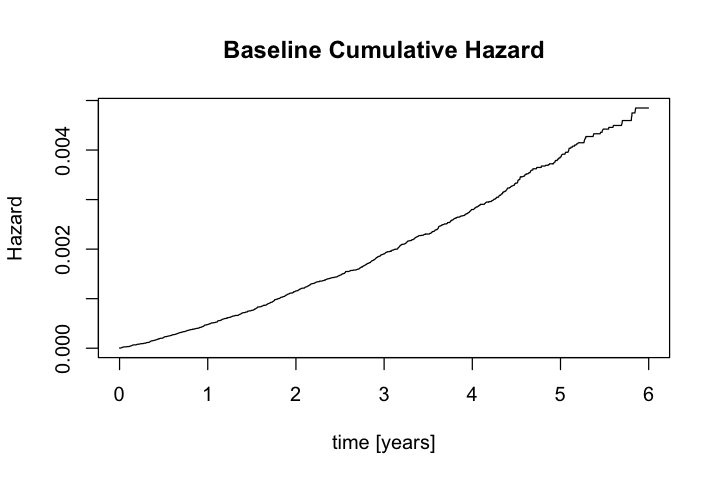

In [13]:
bh = basehaz(best_model,centered = FALSE)

options(repr.plot.width=6, repr.plot.height=4)
plot(bh$time/365,bh$hazard, type = 'l',xlab = 'time [years]',ylab = 'Hazard', main = 'Baseline Cumulative Hazard')

# Build survival curves test set

In [14]:
surv_curves = survfit(best_model,test_df,se.fit = FALSE)$surv
write.csv(surv_curves,file = '../../data/full_predictions_cox.csv',row.names = FALSE)

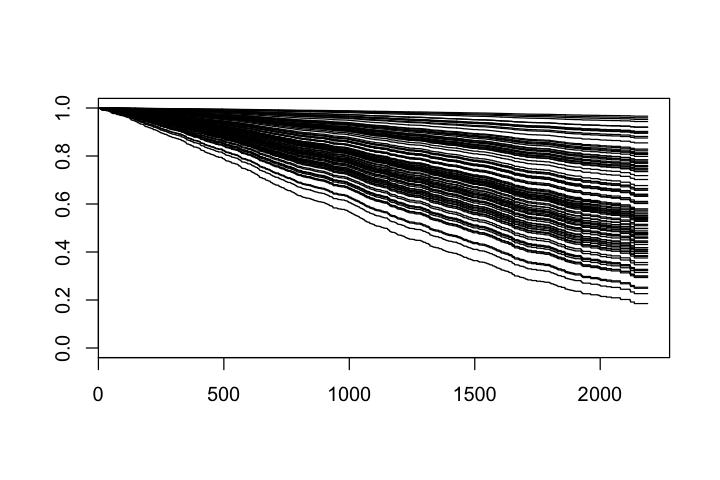

In [15]:
# plot a sample
sample_ids = sample(1:dim(test_df)[1],100)
surv_sample = survfit(best_model,test_df[sample_ids,],se.fit = FALSE)
plot(surv_sample)